# Topic: Fama-French Equity Factors over Business Cycles

* Feburary 20 Python Markdown Submission: Data read-in, visualization, and EDA
* Group members: Kenneth Chen, Yoshiyasu Kawamura, Byungsoo Kim, Patrick Wang
* For the data and detailed python code please visit our GitHub repo: https://github.com/patrickwjwang/equity-cycle


## Background settings

In [16]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)  

## 1. Risk factors data

In [17]:
# Read processed data files
ff6_weekly_df = pd.read_csv(os.path.join(data_dir, 'ff6_weekly.csv'))
ff6_monthly_df = pd.read_csv(os.path.join(data_dir, 'ff6_monthly.csv'))
hxz_weekly_df = pd.read_csv(os.path.join(data_dir, 'hxz_weekly.csv'))
hxz_monthly_df = pd.read_csv(os.path.join(data_dir, 'hxz_monthly.csv'))

In [18]:
# Create summmary stat for weekly ff6
ff6_weekly_summary = ff6_weekly_df.describe()
start, end = min(ff6_weekly_df['Date']), max(ff6_weekly_df['Date'])  # start and end date
print(f"Fama-French 5 factors and momentum start date: {start}; end date {end}")
ff6_weekly_summary

Fama-French 5 factors and momentum start date: 1964-01-03; end date 2023-12-29


,MOM,Mkt-RF,SMB,HML,RMW,CMA,RF
count,3131.000000,3131.000000,3131.000000,3131.000000,3131.000000,3131.000000,3131.000000
mean,0.135596,0.130774,0.037114,0.070952,0.067305,0.063214,0.083331
std,1.925328,2.236785,1.256893,1.390704,0.977707,0.908656,0.061561
min,-15.772907,-17.987191,-9.253229,-9.798088,-7.092451,-4.195031,0.000000
25%,-0.600329,-1.063388,-0.669373,-0.614675,-0.399689,-0.439481,0.030504
50%,0.227305,0.283966,0.049534,0.026954,0.049159,0.028873,0.085029
75%,1.062085,1.383493,0.751181,0.697436,0.500805,0.520756,0.115053
max,12.649785,13.463028,6.306259,11.220550,10.997870,5.536604,0.305372


In [19]:
# Create summmary stat for weekly HXZ
hxz_weekly_summary = hxz_weekly_df.describe()
start, end = min(hxz_weekly_df['Date']), max(hxz_weekly_df['Date'])  # start and end date
print(f"HXZ factors start date: {start}; end date {end}")
hxz_weekly_summary

HXZ factors start date: 1967-01-06; end date 2022-12-30


,RF_HXZ,Mkt-RF_HXZ,ME_HXZ,IA_HXZ,ROE_HXZ,EG_HXZ
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,0.083501,0.131291,0.053665,0.089235,0.125343,0.177427
std,0.064195,2.284046,1.274027,0.933133,1.073423,0.913778
min,-0.000800,-17.991400,-8.652600,-5.495600,-7.206400,-6.822900
25%,0.027025,-1.105950,-0.679600,-0.412650,-0.391250,-0.293200
50%,0.087250,0.286400,0.043400,0.068350,0.168450,0.173350
75%,0.118800,1.424150,0.764500,0.574375,0.682700,0.645775
max,0.342500,13.468000,7.369700,6.960500,9.629700,5.591100


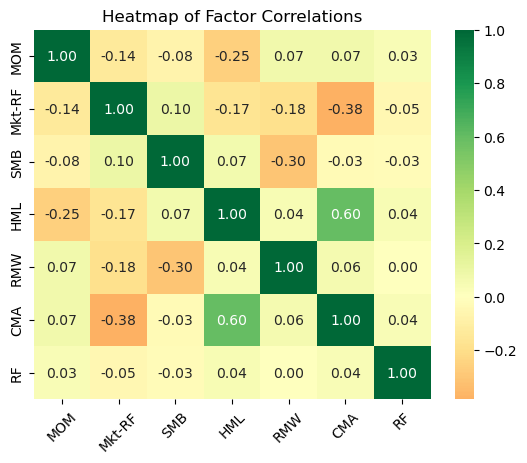

In [20]:
corr_matrix = ff6_weekly_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.xticks(rotation=45)
plt.title('Heatmap of Factor Correlations')
plt.savefig(os.path.join(graph_dir, 'ff6_weekly_heatmap.png'))
plt.show()

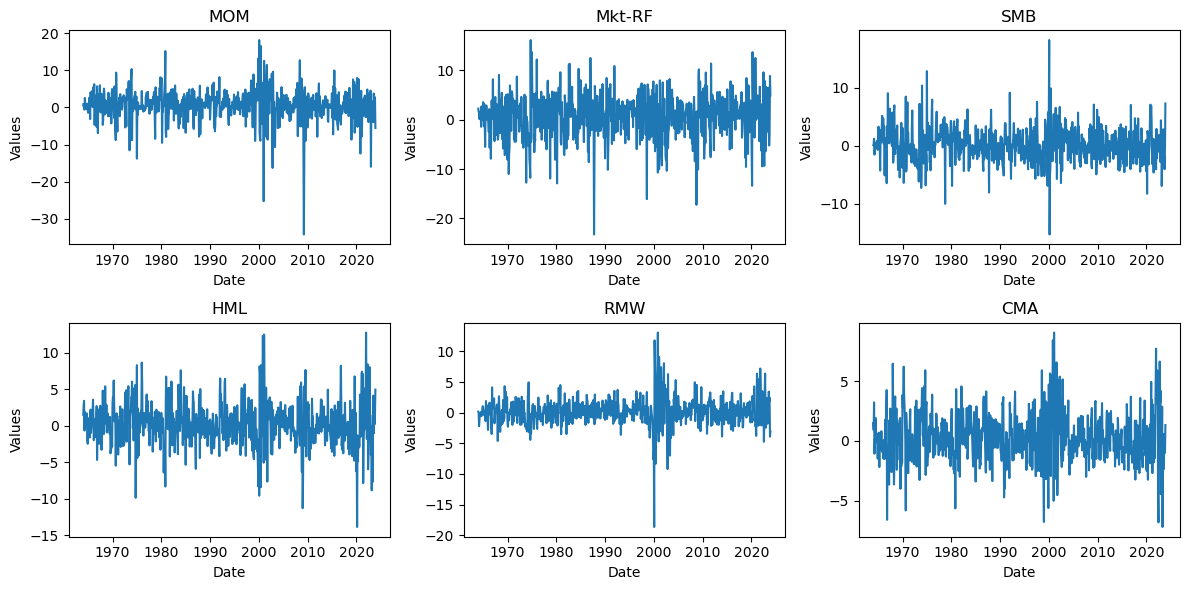

In [21]:
# Line chart for ff6 monthly
ff6_monthly_df['Year_Month'] = pd.to_datetime(ff6_monthly_df['Year_Month'])
variables = ['MOM', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']  # excluding 'RF'

# Create a 2x3 subplo6
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()
for i, var in enumerate(variables):
    axs[i].plot(ff6_monthly_df['Year_Month'], ff6_monthly_df[var])
    axs[i].set_title(var)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Values')
plt.tight_layout()
plt.show()

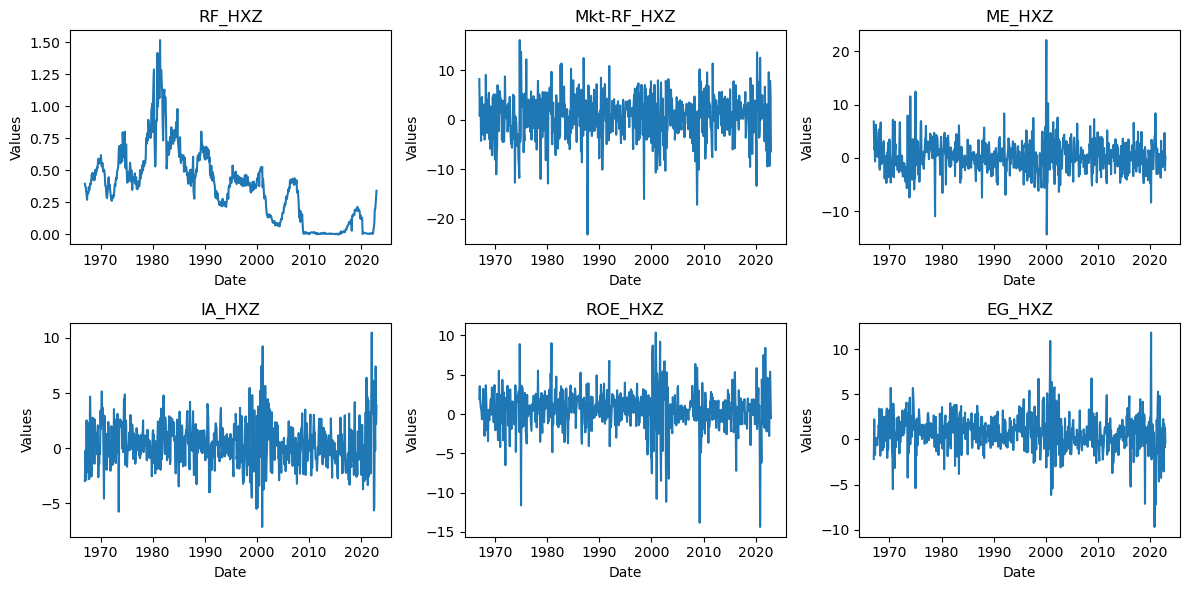

In [22]:
# Line chart for hxz monthly
hxz_monthly_df['Year_Month'] = pd.to_datetime(hxz_monthly_df['Year_Month'])
variables = ['RF_HXZ', 'Mkt-RF_HXZ', 'ME_HXZ', 'IA_HXZ', 'ROE_HXZ', 'EG_HXZ']

# Create a 2x3 subplot
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()
for i, var in enumerate(variables):
    axs[i].plot(hxz_monthly_df['Year_Month'], hxz_monthly_df[var])
    axs[i].set_title(var)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Values')
plt.tight_layout()
plt.show()

## 2. Stock data

In [23]:
# Some EDA using stock data

## 3. Construct optimal potfolios using stock data

We wrote a python class called `OptimalPortfolios`, stored in the `src` directory under the file `optimal_portfolios.py`. The source code and example usage for this class is printed out below for your reference.

In [24]:
from optimal_portfolios import OptimalPortfolios
print(inspect.getsource(OptimalPortfolios))

class OptimalPortfolios:
    """
    OptimalPortfolios calculates optimal portfolio weights using the Efficient Frontier method 
    and computes portfolio returns over different time frames. 
    'Portfolio_1' is the portfolio that achieves 50-quantile stock return with minimized variance
    and 'Portfolio_num_pfo' is the 90-quantile stock return with minimized variance

    Attributes:
        stock_df (DataFrame): Historical stock prices.
        num_pfo (int): Number of portfolios on the efficient frontier.
        pfo_returns (list): List of expected returns for each portfolio.
        pfo_vars (list): List of variances for each portfolio.
    
    Example:
        stock_df = pd.read_csv('stock_data.csv')
        op = OptimalPortfolios(stock_df, num_pfo=5)
        op.calculate_efficient_frontier()
        print(op.weekly_return)
    """

    def __init__(self, stock_df, num_pfo):
        self.stock_df = stock_df
        self.num_pfo = num_pfo
        self._mu = expected_returns.m

In [25]:
# Example usage of OptimalPortfolios using sample data
stock_df = pd.read_parquet(os.path.join(data_dir, 'sp1500_199603_200111.parquet'))

# Initialize the class and calculate efficient frontier
num_pfo = 10
ef_pfo = OptimalPortfolios(stock_df, num_pfo)
ef_pfo.calculate_efficient_frontier()

# Access returns for the optimized portfolio
daily_return_df = ef_pfo.monthly_return
weekly_return_df = ef_pfo.weekly_return
monthly_return_df = ef_pfo.monthly_return
annual_return_df = ef_pfo.annual_return
annual_return_df.head() 

,portfolio_1,portfolio_2,portfolio_3,portfolio_4,portfolio_5,portfolio_6,portfolio_7,portfolio_8,portfolio_9,portfolio_10
Date,,,,,,,,,,
1997-12-31,0.291056,0.305851,0.323519,0.344971,0.368468,0.392649,0.419314,0.445730,0.473978,0.503408
1998-12-31,-0.015105,-0.003537,0.008597,0.029032,0.057392,0.086527,0.115739,0.145245,0.175971,0.210679
1999-12-31,0.027292,0.049184,0.067371,0.081570,0.093759,0.103862,0.115056,0.126832,0.137487,0.147056
2000-12-31,0.172903,0.204511,0.240880,0.278001,0.310402,0.344436,0.376962,0.407809,0.436122,0.463471
2001-12-31,0.185661,0.200994,0.218750,0.235145,0.256178,0.277707,0.301349,0.326634,0.351059,0.373348


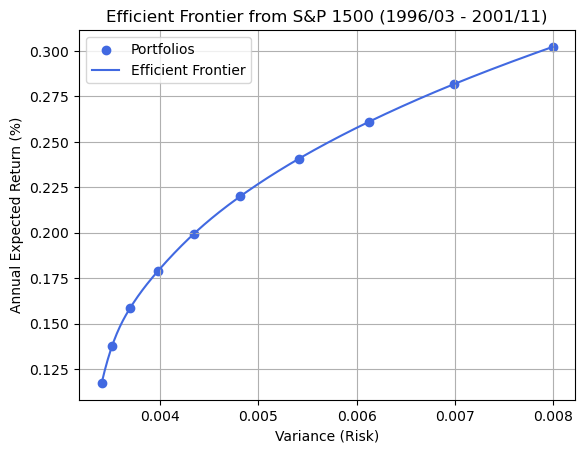

In [37]:
# Convert lists to numpy arrays for easier manipulation
pfo_returns_array = np.array(ef_pfo.pfo_returns)
pfo_vars_array = np.array(ef_pfo.pfo_vars)
sorted_indices = np.argsort(pfo_vars_array)
pfo_vars_sorted = pfo_vars_array[sorted_indices]
pfo_returns_sorted = pfo_returns_array[sorted_indices]

# Get individual stock returns and variances
individual_returns = ef_pfo._mu
individual_vars = np.diag(ef_pfo._cov_matrix)

# Creating the spline to smooth efficent frontier
spline = make_interp_spline(pfo_vars_sorted, pfo_returns_sorted, k=3)  # k is the degree of the spline
smooth_vars = np.linspace(pfo_vars_sorted.min(), pfo_vars_sorted.max(), 300)
smooth_returns = spline(smooth_vars)

# Plotting the efficient frontier using the sample data
plt.scatter(ef_pfo.pfo_vars, ef_pfo.pfo_returns, color='royalblue', label='Portfolios')
plt.plot(smooth_vars, smooth_returns, color='royalblue', label='Efficient Frontier')
plt.title('Efficient Frontier from S&P 1500 (1996/03 - 2001/11)')
plt.xlabel('Variance (Risk)')
plt.ylabel('Annual Expected Return (%)')
plt.grid(True)
plt.legend()
plt.show()
